In [1]:
%load_ext autoreload
%autoreload 2
from utils import plot_utils
from utils import custom_functions as cuf

import os
import sys
#sys.path.append("../") # go to parent 
from OpenEphys_Analysis.utils.custom_functions import update_progress
import glob
import ntpath
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import math
import seaborn as sns
import pandas as pd
import warnings
from itertools import chain
import random
from datetime import datetime

warnings.filterwarnings('ignore')

In [2]:
# Task
BpodProtocol = '/Two_Alternative_Choice/'
# Behavioural data
GeneralDirectory = cuf.get_data_folder() + '/Behavioural_Data/Bpod_data/'

output_directory_name =  'D1andD2opto-learning_Dec21'

outputDir = GeneralDirectory + output_directory_name + '_Analysis/'
if not os.path.isdir(outputDir):
    print('I dont find this')
else:
    # Read the dataframe
    AnimalsDF = pd.read_pickle(outputDir + output_directory_name + '_dataframe.pkl')
    print('Dataframe read')

Dataframe read


In [3]:
# Correct a session that was not properly marked
AnimalsDF.loc[AnimalsDF.SessionID=='D2opto-12 Dec14 13:55', 'Stimulation'] = 'Left'

In [4]:
# Select only the tests done in December
str_format = '%b%d %H:%M'
limit_date = 'Mar01 12:00'
session_times = [datetime.strptime(x, str_format) for x in AnimalsDF.SessionTime.unique()]
date_mask = [x > datetime.strptime(limit_date, str_format) for x in session_times]
selected_dates = [x.strftime(str_format) for x in np.array(session_times)[date_mask]]

In [5]:
AnimalsDF = AnimalsDF[AnimalsDF.SessionTime.isin(selected_dates)]

In [6]:
# Select only the auditory when stimulation happened
protocols_selected = ['Auditory']
AnimalsDF = AnimalsDF[AnimalsDF.Protocol.isin(protocols_selected)]

stim_types = ['Right', 'Left']
AnimalsDF = AnimalsDF[AnimalsDF.Stimulation.isin(stim_types)]

In [7]:
# Remove the first 20 trials of each session
tr_beg_to_rem = 20
AnimalsDF = AnimalsDF[AnimalsDF['TrialIndex'] > tr_beg_to_rem]
print('Removed {} trials from the beginning of each session'.format(tr_beg_to_rem))

Removed 20 trials from the beginning of each session


In [8]:
# read the dataframe if it is there and skip calculations below
random_opto_df = pd.read_pickle(outputDir + output_directory_name + '_random-opto_dataframe.pkl')

In [17]:
# Generate random optostimulation choices for every session
n_times = 1000
data = np.empty([len(pd.unique(AnimalsDF['SessionID'])), 3], dtype=object)

for i, session in enumerate(pd.unique(AnimalsDF['SessionID'])):
    # generate the random dataset, and save it to a general dataframe for later use
    session_df = AnimalsDF[AnimalsDF['SessionID'] == session]
    roc = cuf.get_random_optolike_choices(df=session_df, n_times=n_times)
    _, odf = cuf.splitOpto(session_df)
    roc_ds = np.apply_along_axis(cuf.get_choices, 1, roc, trialsDif=odf['Difficulty'])
    avail_diffs = roc_ds[0,0,:]
    rand_choices_ds = roc_ds[:,1,:]
    # fill
    data[i] = [session, avail_diffs, rand_choices_ds]
    
    update_progress(i / len(pd.unique(AnimalsDF['SessionID'])))

random_opto_df = pd.DataFrame(data, columns=['SessionID', 'Difficulties', 'Random_choices'])
update_progress(1)

Progress: [####################] 100.0%


In [18]:
# Calculate the differences between the random choices and the opto ones to measure the bias

random_opto_df['bias'] = None
random_opto_df['bias_mean'] = None
random_opto_df['bias_std'] = None

for sc, session in enumerate(pd.unique(random_opto_df['SessionID'])):
    session_idx = random_opto_df.index[random_opto_df.SessionID == session].item()
    # get data for opto
    opto_df = AnimalsDF[(AnimalsDF['SessionID'] == session) & (AnimalsDF['OptoStim']==1)]
    trialsDif = np.array(opto_df['TrialHighPerc'])
    sideSelected = np.array(opto_df['FirstPoke'])
    difficulty, opto_perf = cuf.get_choices(sideSelected, trialsDif)
    
    # get data for the shuffles
    updown_list = np.empty(n_times)
    for i in range(n_times):
        y_vals = random_opto_df.loc[session_idx].Random_choices[i]
        # calculate difference and normalize
        updown_list[i] = np.sum(y_vals - opto_perf) / len(difficulty)
    
    random_opto_df.at[session_idx, 'bias'] = updown_list
    random_opto_df.at[session_idx, 'bias_mean'] = np.nanmean(updown_list)
    random_opto_df.at[session_idx, 'bias_std'] = np.nanstd(updown_list)
    
    update_progress((sc + 1) / len(pd.unique(random_opto_df['SessionID'])))

Progress: [####################] 100.0%


Progress: [####################] 100.0%


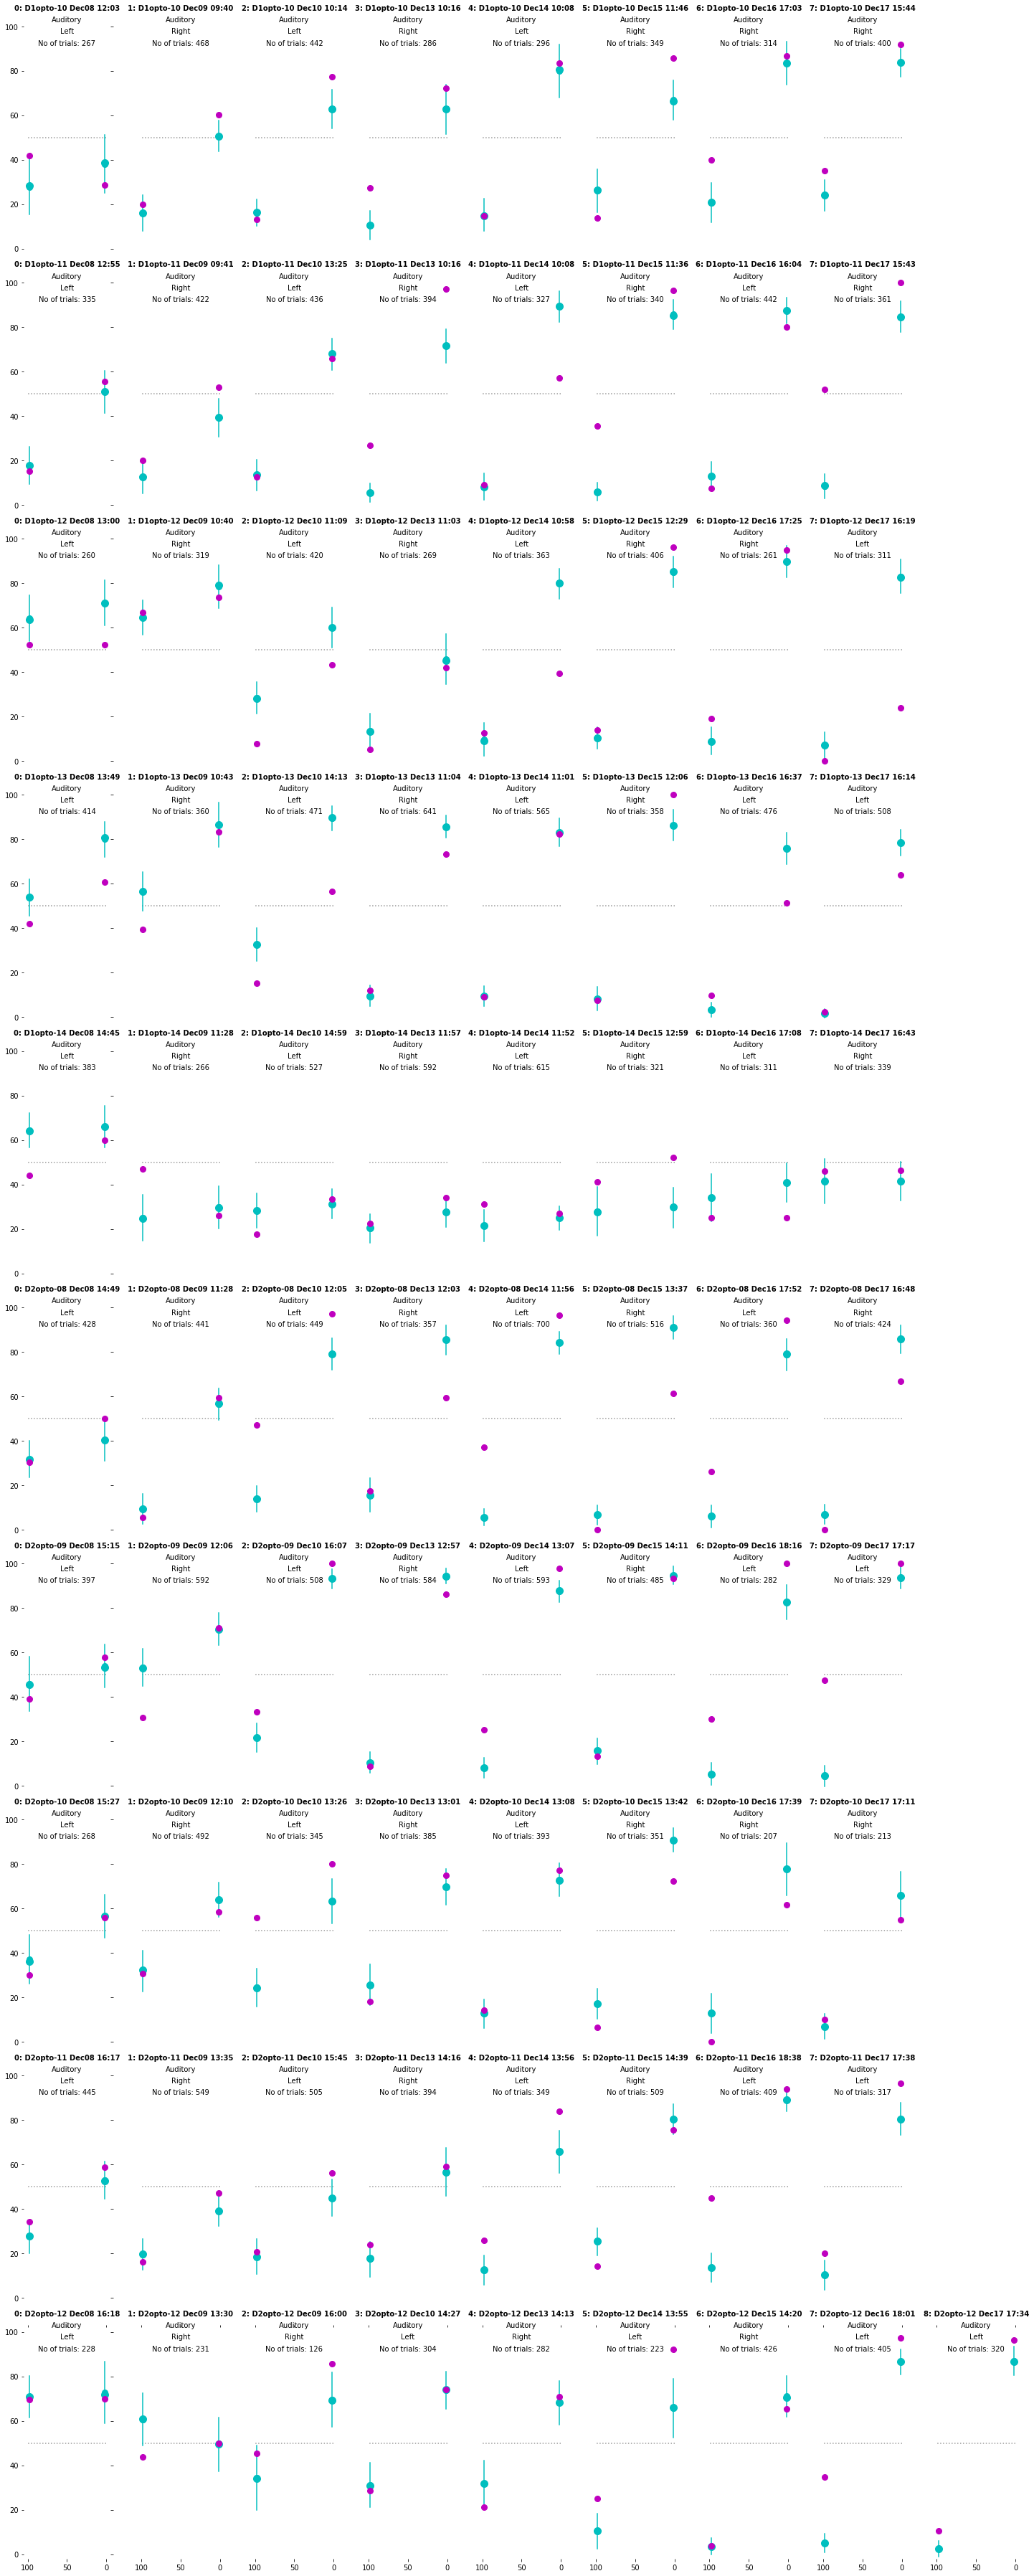

In [19]:
# plot the sessions
# Plot the data with the error bars for the random sampling

CondList = [(AnimalsDF['OptoStim']==0),
            (AnimalsDF['OptoStim']==1)]
ColorList = ['c', 'm']
LabelList = ['Normal', 'Opto']

n_cols = AnimalsDF.groupby('AnimalID')['SessionID'].nunique().max()

fig, axs = plt.subplots(len(pd.unique(AnimalsDF['AnimalID'])), n_cols,
                        figsize=(20, 5 * len(pd.unique(AnimalsDF['AnimalID']))),
                        facecolor='w', edgecolor='k')

fig.subplots_adjust(hspace = .2, wspace=1)

for ax in axs.ravel(): ax.axis('off')

for an_counter, animal in enumerate(pd.unique(AnimalsDF['AnimalID'])):
    animal_df = AnimalsDF[AnimalsDF['AnimalID'] == animal]
    
    for counter, session in enumerate(pd.unique(animal_df['SessionID'])):
        session_df = AnimalsDF[AnimalsDF['SessionID'] == session]
        
        ax = axs[an_counter, counter]        
        ax.hlines(50, 0, 100, linestyles='dotted', alpha=0.4)

        avail_diffs = random_opto_df[random_opto_df.SessionID == session].Difficulties.item()
        rand_choices_ds = random_opto_df[random_opto_df.SessionID == session].Random_choices.item()
        
        plot_utils.plot_random_optolike_choices(df=session_df,
                                                ax=ax,
                                                fake_dataset_m_and_std=[avail_diffs,
                                                                        np.mean(rand_choices_ds, axis=0),
                                                                        np.std(rand_choices_ds, axis=0)])
#         # overlay fits
#         for i, condition in enumerate(CondList):
#             plot_utils.plot_regression(df=animal_df[(animal_df['SessionID'] == session) & condition], ax=ax,
#                                        color=ColorList[i], label=LabelList[i], plot_points=False)
        #axs[counter].set_ylabel('')
        #axs[counter].set_xlabel('')
        ax.axis('on')
        # remove some ticks
        ax.tick_params(which='both', top=False, bottom='on', left='on', right=False,
                       labelleft='on', labelbottom='on')
        if not ax.is_first_col():
            ax.set_ylabel('')
            ax.set_yticks([])
        if not ax.is_last_row():
            ax.set_xlabel('')
            ax.set_xticks([])
                   
        ax.set_ylim(-2., 102.)
        #ax.legend(bbox_to_anchor=(1.05, 1), loc=0, borderaxespad=0.)
        ax.tick_params(which='both', top='off', bottom='on', left='on', right='off',
                       labelleft='on', labelbottom='on')
        # get rid of the frame
        for spine in ax.spines.values():
            spine.set_visible(False)
        
        plt.tight_layout()
        
        ax.invert_xaxis()
        
#         ax.get_legend().remove()
        ax.text(.5,1.05, str(counter) + ': ' + (session), \
                          horizontalalignment='center', fontweight='bold', transform=ax.transAxes)

        ax.text(.5,1, animal_df[(animal_df['SessionID'] == session)].Protocol.unique()[0] , \
                          horizontalalignment='center', transform=ax.transAxes)
        ax.text(.5,.95, animal_df[(animal_df['SessionID'] == session)].Stimulation.unique()[0] , \
                          horizontalalignment='center', transform=ax.transAxes)
        ax.text(.5,.9, 'No of trials: ' + str(len(animal_df[(animal_df['SessionID'] == session)])) , \
                          horizontalalignment='center', transform=ax.transAxes)

    update_progress(an_counter / len(pd.unique(AnimalsDF['AnimalID'])))
    
update_progress(1)
plt.savefig(outputDir + output_directory_name + '_difficulty_significance_for_individual_opto_sessions.pdf', transparent=True, bbox_inches='tight')

plt.show(fig)

In [20]:
# add the performance of that session (use only the normal trials to compute this)
random_opto_df['session_performance'] = None

for session in pd.unique(random_opto_df['SessionID']):
    session_idx = random_opto_df.index[random_opto_df.SessionID == session].item()
    # get data for non-opto trials
    normal_df = AnimalsDF[(AnimalsDF['SessionID'] == session) & (AnimalsDF['OptoStim']==0)]
    # calculate performance
    sess_perf = 100 * np.nansum(normal_df.FirstPokeCorrect) / normal_df.shape[0]
    random_opto_df.at[session_idx, 'session_performance'] = sess_perf

In [21]:
# add the side in which stimulation happened, and translate the bias to contralateral / ipsilateral
random_opto_df['stimulated_side'] = None
random_opto_df['contralateral_bias'] = None

for session in pd.unique(random_opto_df['SessionID']):
    session_idx = random_opto_df.index[random_opto_df.SessionID == session].item()
    # get information
    stim_side = AnimalsDF[AnimalsDF['SessionID'] == session].Stimulation.unique().item()    
    # add info
    random_opto_df.at[session_idx, 'stimulated_side'] = stim_side

    # bias is the normal minus the opto. This means that a positive value is a leftwards bias of the opto trials
    # this is good as a contralateral bias for the trials in which optostimulation occurs in the right side
    # flip the sign of the ones where stimulation happens on the left
    if stim_side == 'Right':
        random_opto_df.at[session_idx, 'contralateral_bias'] = random_opto_df.at[session_idx, 'bias_mean']
    elif stim_side == 'Left':
        random_opto_df.at[session_idx, 'contralateral_bias'] = - random_opto_df.at[session_idx, 'bias_mean']
    else:
        print('Something wrong')

In [22]:
# Get a column with the mouse name
random_opto_df['AnimalID'] = None
# And the type of mouse
random_opto_df['Genotype'] = None

for sc, session in enumerate(pd.unique(random_opto_df['SessionID'])):
    session_idx = random_opto_df.index[random_opto_df.SessionID == session].item()    
    mouse_name = random_opto_df.loc[session_idx].SessionID.split(' ')[0]
    random_opto_df.at[session_idx, 'AnimalID'] = mouse_name
    random_opto_df.at[session_idx,'Genotype'] = mouse_name.split('-')[0]

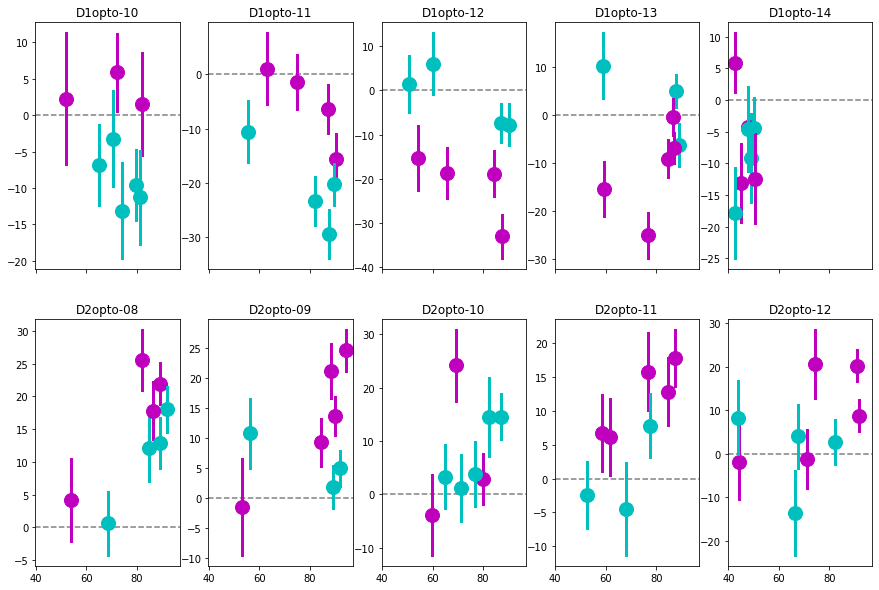

In [23]:
# plot for every mouse the contralateral bias vs the performance of the session
stim_types = ['Right', 'Left']
colors = ['c', 'm']
animals = pd.unique(random_opto_df.AnimalID)
fig, axs = plt.subplots(len(pd.unique(random_opto_df.Genotype)), 5,
                        figsize=(15, len(animals)),
                        sharex=True)#, sharey=True)
axs = axs.ravel()
# for ax in axs.ravel(): ax.axis('off')
for an_c, animal in enumerate(animals):
    ax = axs[an_c]
    ax.set_title(animal)
    ax.axhline(0, color='grey', linestyle='--')
    animal_rdf = random_opto_df[random_opto_df.AnimalID == animal]
    
    for session in pd.unique(animal_rdf.SessionID):
        session_idx = animal_rdf.index[animal_rdf.SessionID == session].item()
        st_t = animal_rdf.loc[session_idx].stimulated_side
        sp = animal_rdf.loc[session_idx].session_performance
        cb = animal_rdf.loc[session_idx].contralateral_bias
        cbs = animal_rdf.loc[session_idx].bias_std
        st_idx = stim_types.index(st_t)

        ax.plot(sp, cb, 'o', ms=14, color=colors[st_idx], alpha = 1)
        ax.plot([sp, sp], [cb-cbs, cb+cbs], color=colors[st_idx], linewidth=3)

plt.savefig(outputDir + output_directory_name + '_bias-through-learning_individual-animals.pdf', transparent=True, bbox_inches='tight')

plt.show()

In [24]:
# fix the 'ceiling' effects, which occur because a mouse cannot move more to one side than 100% of the time

# function to determine which difficulty to look at
def difficulty_for_bias(mouse_line, stimulated_side):
    # create a logic table in order to find which difficulty to look at when calculating the bias
    # this depends on the contingency, on the mouse line, and on the the fiber placement

    # expected movements given the sound (difficulty)
    set_contingency = {'Right': 2.0,
                       'Left': 98.0}

    # expectation (and observation) of bias
    bias_expectation = {'D1opto': 'ipsi',
                        'D2opto': 'contra'}

    # logical table for what to expect given ipsi/contra
    # e.g. if you expect an ipsi bias and the fiber is on the right, you wanna look at the left movements
    # -----------------------------
    #           |   Right   Left
    #           |-----------------
    #  ipsi     |   Left    Right
    #  contra   |   Right   Left
    # -----------------------------
    logic_rows = ['ipsi', 'contra']
    logic_cols = ['Right', 'Left']
    logic_table = [['Left', 'Right'], ['Right', 'Left']]
    
    expected_bias = bias_expectation[mouse_line]
    table_row = logic_rows.index(expected_bias)
    table_col = logic_cols.index(stimulated_side)
    affected_side = logic_table[table_row][table_col]
    
    return set_contingency[affected_side]

In [25]:
# recalculate bias, mean and std
random_opto_df['bias_exp'] = None
random_opto_df['bias_mean_exp'] = None
random_opto_df['bias_std_exp'] = None

for sc, session in enumerate(pd.unique(random_opto_df['SessionID'])):
    session_idx = random_opto_df.index[random_opto_df.SessionID == session].item()
    # get data for opto
    opto_df = AnimalsDF[(AnimalsDF['SessionID'] == session) & (AnimalsDF['OptoStim']==1)]
    trialsDif = np.array(opto_df['TrialHighPerc'])
    sideSelected = np.array(opto_df['FirstPoke'])
    difficulty, opto_perf = cuf.get_choices(sideSelected, trialsDif)
    
    mouse_line = random_opto_df.loc[session_idx].Genotype
    stim_side = random_opto_df.loc[session_idx].stimulated_side
    rand_difs = random_opto_df.loc[session_idx].Difficulties
    
    # select the difference to look at for this session
    dif_to_consider = difficulty_for_bias(mouse_line, stim_side)
    dif_idx = list(rand_difs).index(dif_to_consider)
    opto_dif_idx = list(difficulty).index(dif_to_consider)
        
    # get data for the shuffles
    updown_list = np.empty(n_times)
    for i in range(n_times):
        y_vals = random_opto_df.loc[session_idx].Random_choices[i]
        updown_list[i] = y_vals[dif_idx] - opto_perf[opto_dif_idx]
    
    random_opto_df.at[session_idx, 'bias_exp'] = updown_list
    random_opto_df.at[session_idx, 'bias_mean_exp'] = np.nanmean(updown_list)
    random_opto_df.at[session_idx, 'bias_std_exp'] = np.nanstd(updown_list)
    
    update_progress((sc + 1) / len(pd.unique(random_opto_df['SessionID'])))


Progress: [####################] 100.0%


In [26]:
# recalculate bias
random_opto_df['contralateral_bias_exp'] = None

for session in pd.unique(random_opto_df['SessionID']):
    session_idx = random_opto_df.index[random_opto_df.SessionID == session].item()
    # get information
    stim_side = AnimalsDF[AnimalsDF['SessionID'] == session].Stimulation.unique().item()    

    # bias is the normal minus the opto. This means that a positive value is a leftwards bias of the opto trials
    # this is good as a contralateral bias for the trials in which optostimulation occurs in the right side
    # flip the sign of the ones where stimulation happens on the left
    if stim_side == 'Right':
        random_opto_df.at[session_idx, 'contralateral_bias_exp'] = random_opto_df.at[session_idx, 'bias_mean_exp']
    elif stim_side == 'Left':
        random_opto_df.at[session_idx, 'contralateral_bias_exp'] = - random_opto_df.at[session_idx, 'bias_mean_exp']
    else:
        print('Something wrong')

In [27]:
# save the dataframe
random_opto_df.to_pickle(outputDir + output_directory_name + '_random-opto_dataframe.pkl')

In [9]:
# reselect dates as above
dates_in_format = [' '.join(x.split(' ')[1:]) for x in random_opto_df.SessionID.values]
dates_in_format_mask = [item in selected_dates for item in dates_in_format]
random_opto_df = random_opto_df[dates_in_format_mask]

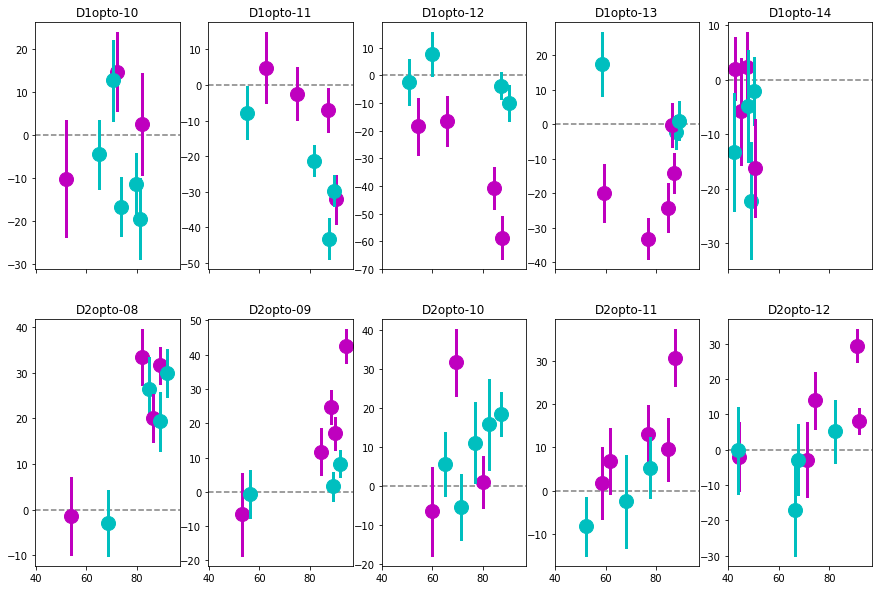

In [10]:
# replot the above

stim_types = ['Right', 'Left']
colors = ['c', 'm']
animals = pd.unique(random_opto_df.AnimalID)
fig, axs = plt.subplots(len(pd.unique(random_opto_df.Genotype)), 5,
                        figsize=(15, len(animals)),
                        sharex=True)#, sharey=True)
axs = axs.ravel()
# for ax in axs.ravel(): ax.axis('off')
for an_c, animal in enumerate(animals):
    ax = axs[an_c]
    ax.set_title(animal)
    ax.axhline(0, color='grey', linestyle='--')
    animal_rdf = random_opto_df[random_opto_df.AnimalID == animal]
    
    for session in pd.unique(animal_rdf.SessionID):
        session_idx = animal_rdf.index[animal_rdf.SessionID == session].item()
        st_t = animal_rdf.loc[session_idx].stimulated_side
        sp = animal_rdf.loc[session_idx].session_performance
        cb = animal_rdf.loc[session_idx].contralateral_bias_exp
        cbs = animal_rdf.loc[session_idx].bias_std_exp
        st_idx = stim_types.index(st_t)

        ax.plot(sp, cb, 'o', ms=14, color=colors[st_idx], alpha = 1)
        ax.plot([sp, sp], [cb-cbs, cb+cbs], color=colors[st_idx], linewidth=3)

plt.savefig(outputDir + output_directory_name + '_bias-through-learning_individual-animals_EXPECTED.pdf', transparent=True, bbox_inches='tight')

plt.show()

In [11]:
# select one side for each mouse and plot them together
side_selection = {'D1opto-10': 'Right',
                  'D1opto-11': 'Right',
                  'D1opto-12': 'Left',
                  'D1opto-13': 'Left',
                  'D1opto-14': None,
                  'D2opto-08': 'Left',
                  'D2opto-09': 'Left',
                  'D2opto-10': 'Right',
                  'D2opto-11': 'Left',
                  'D2opto-12': 'Left',}

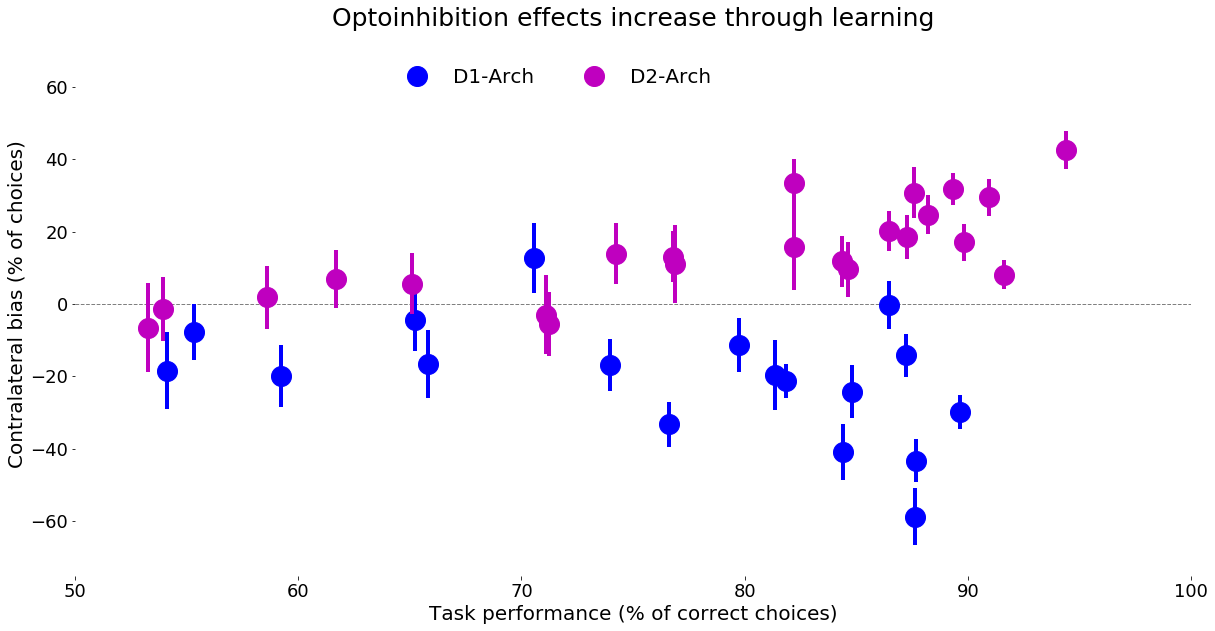

In [12]:
# plot them all together
genotypes = ['D1opto', 'D2opto']
colors = ['b', 'm']
labels_for_legend = ['D1-Arch', 'D2-Arch']
animals = pd.unique(random_opto_df.AnimalID)

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.axhline(0, color='grey', linestyle='--', linewidth=1)

for an_c, animal in enumerate(animals):
    
    animal_rdf = random_opto_df[random_opto_df.AnimalID == animal]
    side_to_plot = side_selection[animal]
    
    for session in pd.unique(animal_rdf.SessionID):
        session_idx = animal_rdf.index[animal_rdf.SessionID == session].item()
        st_t = animal_rdf.loc[session_idx].stimulated_side
        if st_t == side_to_plot:
            sp = animal_rdf.loc[session_idx].session_performance
            cb = animal_rdf.loc[session_idx].contralateral_bias_exp
            cbs = animal_rdf.loc[session_idx].bias_std_exp
            genot = animal_rdf.loc[session_idx].Genotype
            g_idx = genotypes.index(genot)
            gfl = labels_for_legend[g_idx]

            ax.plot(sp, cb, 'o', ms=20, color=colors[g_idx], alpha = 1, label=gfl)
            ax.plot([sp, sp], [cb-cbs, cb+cbs], color=colors[g_idx], linewidth=4)

#beautify the plot
ax.set_ylim(-75, 75)
ax.set_xlim(50, 100)

# get rid of the frame
for spine in ax.spines.values():
    spine.set_visible(False)

# set labels
ax.set_ylabel('Contralateral bias (% of choices)', fontsize=20)
ax.set_xlabel('Task performance (% of correct choices)', fontsize=20)
ax.set_title('Optoinhibition effects increase through learning', fontsize=25)

# add legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), frameon=False, loc=(.32, .85), ncol=2, fontsize=20)
# ax.legend()
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(18) 

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(18)
plt.savefig(outputDir + output_directory_name + '_bias-through-learning-grouped_expected_side-selected.pdf', transparent=True, bbox_inches='tight')

plt.show()

In [125]:
# do binning? how to merge different animals? plot all the shuffles and fit?
df_for_bin

,SessionID,Difficulties,Random_choices,bias,bias_mean,bias_std,session_performance,stimulated_side,contralateral_bias,AnimalID,Genotype,bias_exp,bias_mean_exp,bias_std_exp,contralateral_bias_exp
1,D1opto-10 Dec09 09:40,"[2.0, 98.0]","[[54.71698113207548, 33.33333333333333], [49.0...","[3.836477987421384, -10.898472596585805, -8.56...",-7.06568,5.18918,65.2284,Right,-7.06568,D1opto-10,D1opto,"[13.333333333333332, -10.476190476190462, -15....",-4.52857,7.81736,-4.52857
3,D1opto-10 Dec13 10:16,"[2.0, 98.0]","[[55.55555555555556, 18.181818181818187], [66....","[-12.878787878787877, -11.868686868686872, -17...",-13.1581,6.40739,73.9837,Right,-13.1581,D1opto-10,D1opto,"[-9.090909090909083, -18.181818181818187, -18....",-16.7273,6.63325,-16.7273
5,D1opto-10 Dec15 11:46,"[2.0, 98.0]","[[75.0, 18.181818181818187], [46.4285714285714...","[-3.0844155844155914, -10.55194805194807, 3.24...",-3.33799,6.5003,70.5686,Right,-3.33799,D1opto-10,D1opto,"[4.54545454545454, 18.181818181818166, 13.6363...",12.6955,9.19952,12.6955
6,D1opto-10 Dec16 17:03,"[2.0, 98.0]","[[86.66666666666667, 14.999999999999991], [80....","[-12.5, -18.33333333333333, -11.66666666666666...",-11.6117,6.42487,81.362,Right,-11.6117,D1opto-10,D1opto,"[-25.0, -29.999999999999986, -29.9999999999999...",-19.53,9.15036,-19.53
7,D1opto-10 Dec17 15:44,"[2.0, 98.0]","[[81.08108108108108, 27.027027027027017], [81....","[-9.45945945945946, -16.216216216216214, -9.45...",-9.71757,4.68444,79.7546,Right,-9.71757,D1opto-10,D1opto,"[-8.108108108108112, -21.62162162162162, -16.2...",-11.3216,6.88912,-11.3216
9,D1opto-11 Dec09 09:41,"[2.0, 98.0]","[[44.11764705882353, 14.28571428571428], [35.2...","[-7.2689075630252065, -11.680672268907554, -10...",-10.5824,5.40542,55.3134,Right,-10.5824,D1opto-11,D1opto,"[-5.714285714285717, -5.714285714285717, -15.2...",-7.7619,7.18574,-7.7619
11,D1opto-11 Dec13 10:16,"[2.0, 98.0]","[[66.66666666666667, 0.0], [66.66666666666667,...","[-28.484848484848477, -25.15151515151515, -29....",-23.3917,4.42322,81.8731,Right,-23.3917,D1opto-11,D1opto,"[-26.66666666666666, -19.999999999999996, -19....",-21.2833,4.17236,-21.2833
13,D1opto-11 Dec15 11:36,"[2.0, 98.0]","[[93.10344827586208, 0.0], [68.96551724137932,...","[-19.46607341490544, -26.696329254727473, -26....",-20.4289,3.76033,89.6429,Right,-20.4289,D1opto-11,D1opto,"[-35.48387096774193, -25.806451612903228, -35....",-29.7129,4.12409,-29.7129
15,D1opto-11 Dec17 15:43,"[2.0, 98.0]","[[89.28571428571428, 12.00000000000001], [89.2...","[-25.357142857142854, -29.35714285714286, -36....",-29.248,4.25053,87.6623,Right,-29.248,D1opto-11,D1opto,"[-39.999999999999986, -48.0, -48.0, -48.0, -43...",-43.196,5.49996,-43.196
18,D1opto-12 Dec08 13:00,"[2.0, 98.0]","[[66.66666666666667, 52.38095238095237], [66.6...","[7.1428571428571495, 19.047619047619058, 7.142...",14.3257,7.21818,54.1284,Left,-14.3257,D1opto-12,D1opto,"[14.285714285714299, 14.285714285714299, 14.28...",18.4135,10.0147,-18.4135


In [121]:
# Calculate, when in learning, the biases become significant. Differently for D1 and D2

# TODO Select only one side per animal

# generate a binned session performance, grouping all the random choices for the sessions contained within
# save all in a diccionary
binned_dict = {'genotype': [],
               'performance_window': [],
               'contra_biases': [],
               'contra_bias_mean': [],
               'contra_bias_std': [],
               'contra_bias_upper_percentile': [],
               'contra_bias_lower_percentile': [],
               'n_sessions': [],
               'n_animals': [],
               'significance_expected_bias': []}

# select only one side per animal!!!!!!!!!!!!!
idxs_to_keep = []
animals = pd.unique(random_opto_df.AnimalID)
for an_c, animal in enumerate(animals):
    animal_index = random_opto_df[random_opto_df.AnimalID == animal].index.values
    side_to_plot = side_selection[animal]
    st_t = random_opto_df.loc[animal_index].stimulated_side
    idxs_to_keep.append(st_t[st_t == side_to_plot].index.values)
    
df_for_bin = random_opto_df.loc[[item for sublist in idxs_to_keep for item in sublist]].copy()
# binned_window = 10
performance_windows = [[0, 60], [60, 70], [70, 80], [80, 90]]#, [90, 100]]

for genot in ['D1opto', 'D2opto']:
    # subselect the dataframe
    genotdf = df_for_bin[df_for_bin.Genotype == genot].copy()

    for bracket in performance_windows:
        # find sessions belonging to that bracket
        bracket_mask = np.logical_and(bracket[0] <= genotdf.session_performance, genotdf.session_performance < bracket[1])
        subdf = genotdf[bracket_mask].copy()
        # extract the contralateral biases of random choices
        contralateral_bias_exp_merge = []
        n_sess = subdf.shape[0]
        n_ans = len(np.unique(subdf.AnimalID))
        for i in range(n_sess):
            cbe = subdf.iloc[i].bias_exp
            # get contra value
            if subdf.iloc[i].stimulated_side == 'Left':
                cbe = [-x for x in cbe]
            contralateral_bias_exp_merge.append(cbe)
        # flatten
        contralateral_bias_exp_merge = [item for sublist in contralateral_bias_exp_merge for item in sublist]

        # append to dicc
        binned_dict['genotype'].append(genot)
        binned_dict['performance_window'].append(bracket[1] - 5)
        binned_dict['contra_biases'].append(contralateral_bias_exp_merge)
        binned_dict['contra_bias_mean'].append(np.mean(contralateral_bias_exp_merge))
        binned_dict['contra_bias_std'].append(np.std(contralateral_bias_exp_merge))
        binned_dict['contra_bias_upper_percentile'].append(np.percentile(contralateral_bias_exp_merge, 97.5))
        binned_dict['contra_bias_lower_percentile'].append(np.percentile(contralateral_bias_exp_merge, 2.5))
        binned_dict['n_sessions'].append(n_sess)
        binned_dict['n_animals'].append(n_ans)
        if genot == 'D1opto':
            n_sig = np.sum([x > 0 for x in contralateral_bias_exp_merge])
        if genot == 'D2opto':
            n_sig = np.sum([x < 0 for x in contralateral_bias_exp_merge])
        sig = n_sig / len(contralateral_bias_exp_merge)
        binned_dict['significance_expected_bias'].append(sig)

# create df
binned_df = pd.DataFrame(binned_dict)

# add lower and upper std
binned_df['lower_std'] = binned_df.contra_bias_mean - binned_df.contra_bias_std
binned_df['upper_std'] = binned_df.contra_bias_mean + binned_df.contra_bias_std

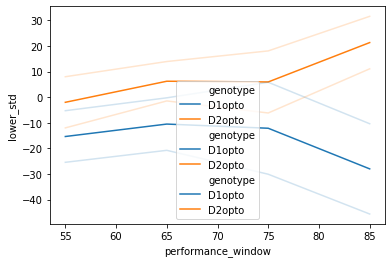

In [126]:
sns.lineplot(data=binned_df, x='performance_window', y='contra_bias_mean', hue='genotype')
sns.lineplot(data=binned_df, x='performance_window', y='upper_std', hue='genotype', alpha=.2)
sns.lineplot(data=binned_df, x='performance_window', y='lower_std', hue='genotype', alpha=.2)
plt.gca().legend()
plt.show()

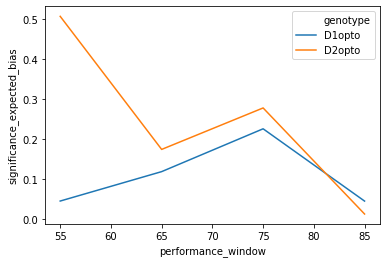

In [123]:
sns.lineplot(data=binned_df, x='performance_window', y='significance_expected_bias', hue='genotype')

In [ ]:
# add regression

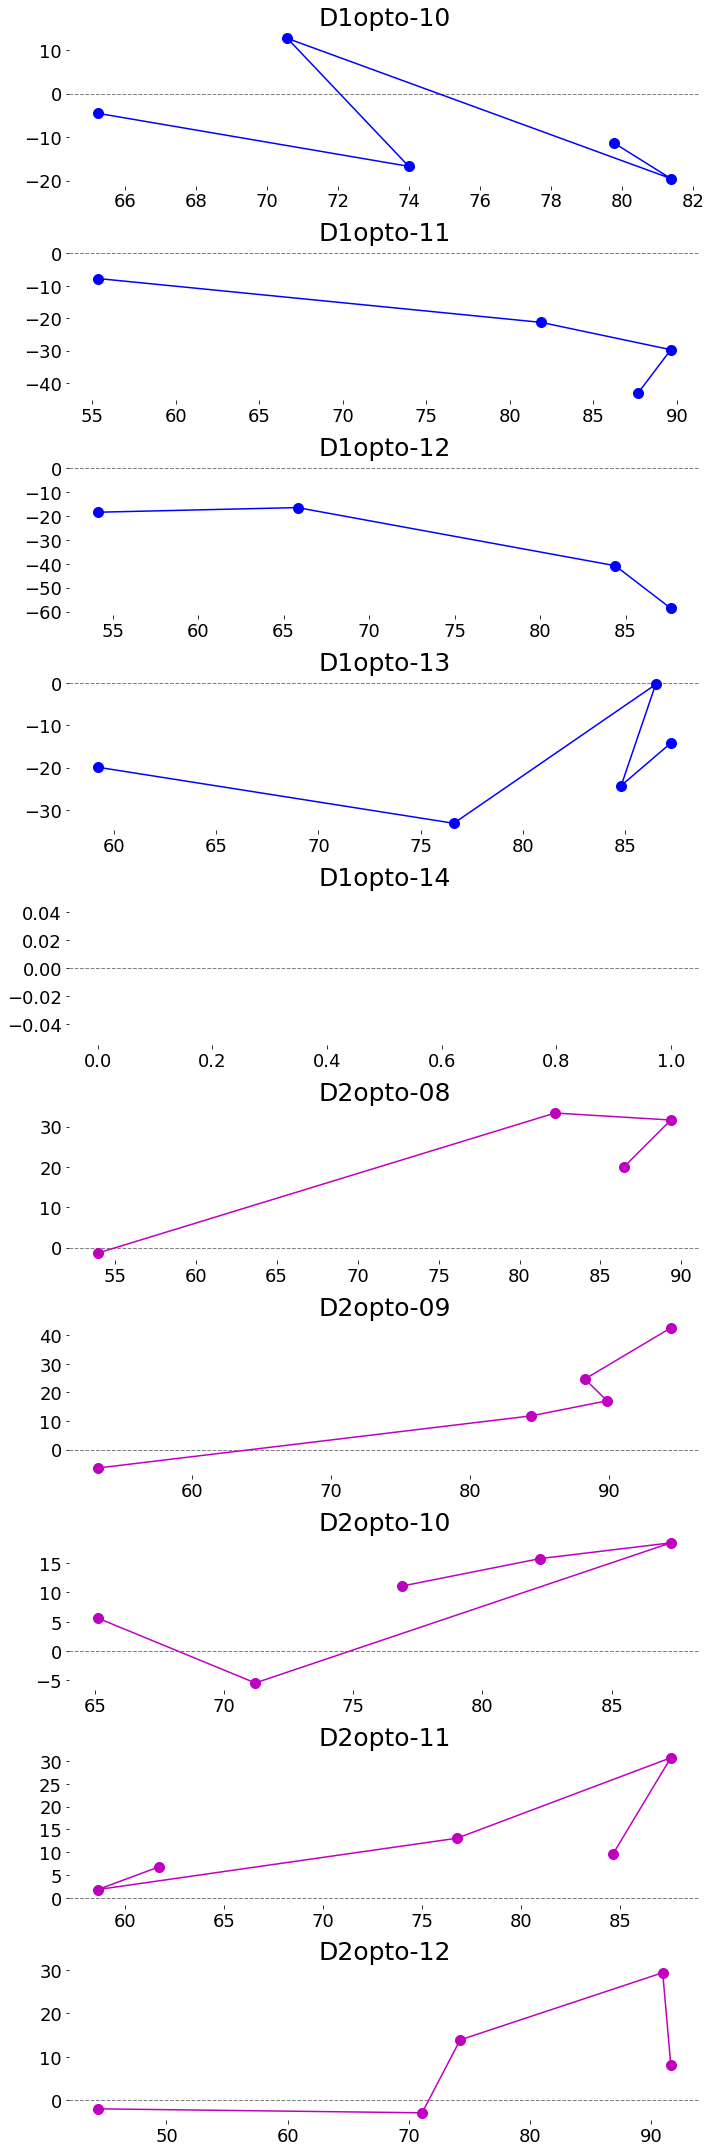

In [13]:
# calculate the slope (binning first?) for each animal and plot?
# plot them all together
genotypes = ['D1opto', 'D2opto']
colors = ['b', 'm']
labels_for_legend = ['D1-Arch', 'D2-Arch']
animals = pd.unique(random_opto_df.AnimalID)

fig, axs = plt.subplots(len(animals), 1, figsize=(10, 3*len(animals)))
axs=axs.ravel()
for ax in axs:
    ax.axhline(0, color='grey', linestyle='--', linewidth=1)

for an_c, animal in enumerate(animals):
    
    ax = axs[an_c]
    
    animal_rdf = random_opto_df[random_opto_df.AnimalID == animal]
    side_to_plot = side_selection[animal]
    
    sp_list = []
    cb_list =[]
    
    for session in pd.unique(animal_rdf.SessionID):
        session_idx = animal_rdf.index[animal_rdf.SessionID == session].item()
        st_t = animal_rdf.loc[session_idx].stimulated_side
        if st_t == side_to_plot:
            sp = animal_rdf.loc[session_idx].session_performance
            cb = animal_rdf.loc[session_idx].contralateral_bias_exp
            sp_list.append(sp)
            cb_list.append(cb)
            cbs = animal_rdf.loc[session_idx].bias_std_exp
            genot = animal_rdf.loc[session_idx].Genotype
            g_idx = genotypes.index(genot)
            gfl = labels_for_legend[g_idx]

    ax.plot(sp_list, cb_list, '.-', ms=20, color=colors[g_idx], alpha = 1, label=gfl)

    #beautify the plot
#     ax.set_ylim(-75, 75)
#     ax.set_xlim(50, 100)

    # get rid of the frame
    for spine in ax.spines.values():
        spine.set_visible(False)

    # set labels
#     ax.set_ylabel('Contralateral bias (% of choices)', fontsize=20)
#     ax.set_xlabel('Task performance (% of correct choices)', fontsize=20)
    ax.set_title(animal, fontsize=25)

#     # add legend
#     handles, labels = ax.get_legend_handles_labels()
#     by_label = dict(zip(labels, handles))
#     fig.legend(by_label.values(), by_label.keys(), frameon=False, loc=(.32, .85), ncol=2, fontsize=20)
    # ax.legend()
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(18) 

    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(18)

plt.tight_layout()

plt.savefig(outputDir + output_directory_name + '_bias-through-learning-grouped_expected_side-selected_individual-lines.pdf', transparent=True, bbox_inches='tight')

plt.show()

In [14]:
# create a new dataframe to hold the information necessary to generate individual regression lines,
# and to generate shuffled dataframes
# This dataframe only has information about the side selected for each animal

# columns: animal_id | genotype | session_performance | contralateral_bias_exp
animal_id_list = []
genotype_list = []
session_performance_list = []
contra_bias_list = []

animals = pd.unique(random_opto_df.AnimalID)
for animal in animals:
    animal_rdf = random_opto_df[random_opto_df.AnimalID == animal]
    side_to_plot = side_selection[animal]    
    for session in pd.unique(animal_rdf.SessionID):
        session_idx = animal_rdf.index[animal_rdf.SessionID == session].item()
        st_t = animal_rdf.loc[session_idx].stimulated_side
        if st_t == side_to_plot:
            sp = animal_rdf.loc[session_idx].session_performance
            cb = animal_rdf.loc[session_idx].contralateral_bias_exp
            session_performance_list.append(sp)
            contra_bias_list.append(cb)
            genotype_list.append(animal_rdf.loc[session_idx].Genotype)
            animal_id_list.append(animal)

simplified_df = pd.DataFrame({'animal_id': animal_id_list,
                              'genotype': genotype_list,
                              'session_performance': session_performance_list,
                              'contralateral_bias': contra_bias_list})

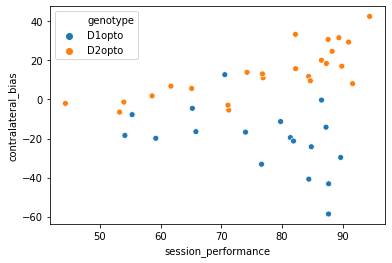

In [15]:
sns.scatterplot(data=simplified_df, x='session_performance', y='contralateral_bias', hue='genotype')

In [17]:
# calculate slopes and generate shuffles of biases per mouse to get the significance for each individual
def get_fit_coefs(df):
    x = df.session_performance
    y = df.contralateral_bias
    return np.polyfit(x, y, 1)

# save all in a diccionary
reg_dicc = {'animals': [],
            'genotypes': [],
            'reg_coefs': [],
            'fits': [],
            'predicted_matrices': [],
            'shuffled_coefficients': []}

xs = range(50,100)
shuffle_times = 100

for animal in simplified_df.animal_id.unique():
    reg_df = simplified_df[simplified_df.animal_id == animal].copy()
    slope, intercept = get_fit_coefs(reg_df)

    # get a list of coefficients for suffled dataframes
    shuffled_slopes = np.zeros(shuffle_times)
    shuffled_int = np.zeros(shuffle_times)
    # generate a matrix of predictions
    predicted_matrix = np.zeros([shuffle_times, len(xs)])

    for i in range(shuffle_times):
        # shuffle dataframe
        shuffled_df = reg_df.copy()
        np.random.shuffle(shuffled_df.contralateral_bias.values)
        # get coefficients
        shuffled_slopes[i], shuffled_int[i] = get_fit_coefs(shuffled_df)
        # fill matrix
        predicted_matrix[i,:] = shuffled_int[i] + shuffled_slopes[i] * xs

    # fill diccionary
    reg_dicc['animals'].append(animal)
    reg_dicc['genotypes'].append(simplified_df[simplified_df.animal_id==animal].genotype.unique()[0])
    reg_dicc['reg_coefs'].append([slope, intercept])
    reg_dicc['fits'].append(intercept + slope * xs)
    reg_dicc['predicted_matrices'].append(predicted_matrix)
    reg_dicc['shuffled_coefficients'].append([shuffled_slopes, shuffled_int])


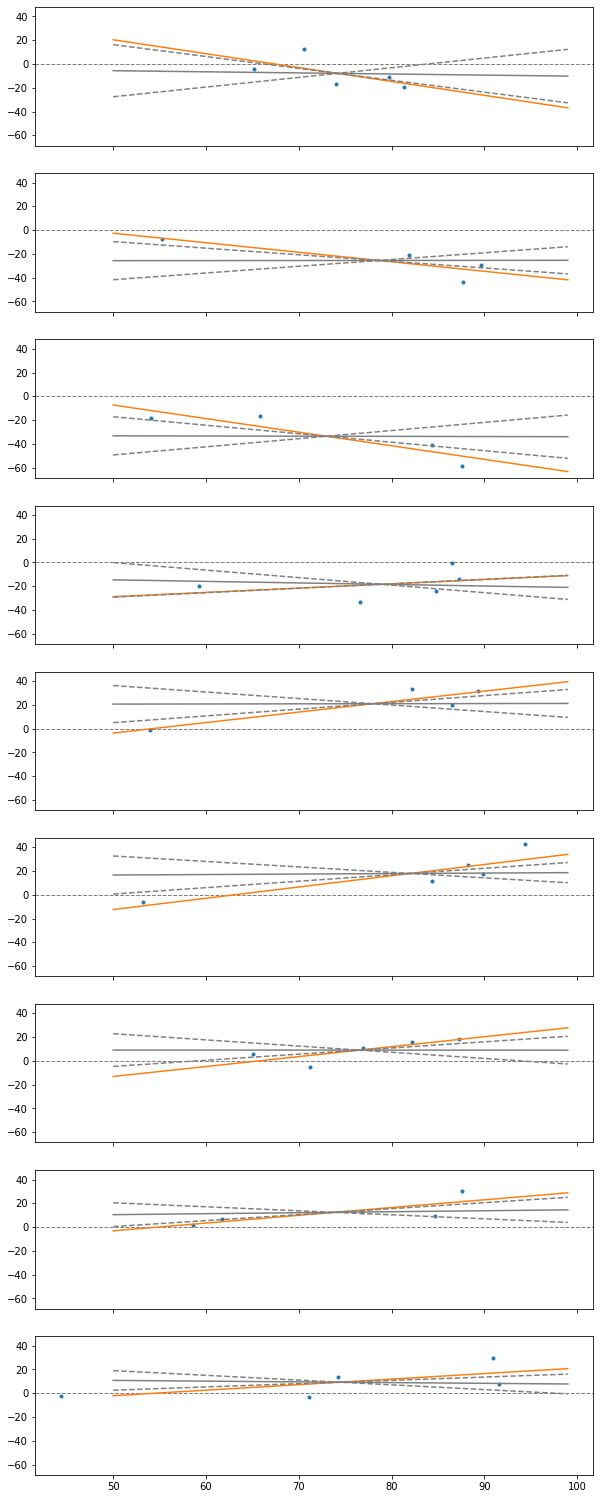

In [18]:
# do plotting
genotypes = ['D1opto', 'D2opto']
colors = ['b', 'm']
labels_for_legend = ['D1-Arch', 'D2-Arch']
animals = pd.unique(simplified_df.animal_id)

fig, axs = plt.subplots(len(animals), 1, figsize=(10, 3*len(animals)), sharex=True, sharey=True)
axs=axs.ravel()
for ax in axs:
    ax.axhline(0, color='grey', linestyle='--', linewidth=1)

for an_c, animal in enumerate(animals):
    
    ax = axs[an_c]
    reg_df = simplified_df[simplified_df.animal_id == animal].copy()
    dicc_an_index = reg_dicc['animals'].index(animal)
    slope, intercept = reg_dicc['reg_coefs'][dicc_an_index]
    predicted_matrix = reg_dicc['predicted_matrices'][dicc_an_index]
    predicted_means = np.mean(predicted_matrix, axis=0)
    predicted_stds = np.std(predicted_matrix, axis=0)

    ax.plot(reg_df.session_performance, reg_df.contralateral_bias , '.')
    ax.plot(xs, intercept + slope*xs)
    
    ax.plot(xs, predicted_means, color='gray')
    ax.plot(xs, predicted_means + predicted_stds, color='gray', linestyle='--')
    ax.plot(xs, predicted_means - predicted_stds, color='gray', linestyle='--')
    
# plt.show()

In [19]:
# calculate a random distribution of slopes, combining both genotypes
# from the random fits, select one for each mouse, and get the mean
# out of that select mean and std
group_shuffle_times = 1000

num_of_animals = len(reg_dicc['predicted_matrices'])
group_shuffle_array = np.zeros([group_shuffle_times, len(xs)])

# for loop
for i in range(group_shuffle_times):
    shuffle_event_matrix = np.zeros([num_of_animals, len(xs)])
    for animal_counter in range(num_of_animals):
        # pick a random iteration of the matrix for that animal
        random_idx = np.random.choice(range(shuffle_times))
        shuffle_event_matrix[animal_counter, :] = reg_dicc['predicted_matrices'][animal_counter][random_idx, :]

    # append to the mean array
    group_shuffle_array[i, :] = np.mean(shuffle_event_matrix, axis=0)

# calculate mean and std
group_shuffle_mean = np.mean(group_shuffle_array, axis=0)
group_shuffle_std = np.mean(group_shuffle_array, axis=0)

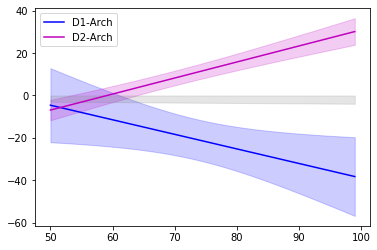

In [20]:
# do this for the population, combining genotypes

genotypes = ['D1opto', 'D2opto']
colors = ['b', 'm']
labels_for_legend = ['D1-Arch', 'D2-Arch']

for gcount, genotype in enumerate(np.unique(reg_dicc['genotypes'])):
    # find indexes for that genotype
    gmask = np.where([g == genotype for g in reg_dicc['genotypes']])[0]

    # get means and stds
    fits_array = np.zeros([len(gmask), len(xs)])
    for i, idx in enumerate(gmask):
        fits_array[i,:] = reg_dicc['fits'][idx]
    genot_means = np.mean(fits_array, axis=0)
    genot_stds = np.std(fits_array, axis=0)
    
    genot_idx = genotypes.index(genotype)
    
    plt.plot(xs, genot_means, color=colors[genot_idx], label=labels_for_legend[genot_idx])
    plt.fill_between(xs, genot_means - genot_stds, genot_means + genot_stds,
                     color=colors[genot_idx], alpha=0.2)
    

# plot random
plt.fill_between(xs,
                 group_shuffle_mean - group_shuffle_std,
                 group_shuffle_mean + group_shuffle_std,
                 color='grey', alpha=0.2)

plt.legend()
plt.show()

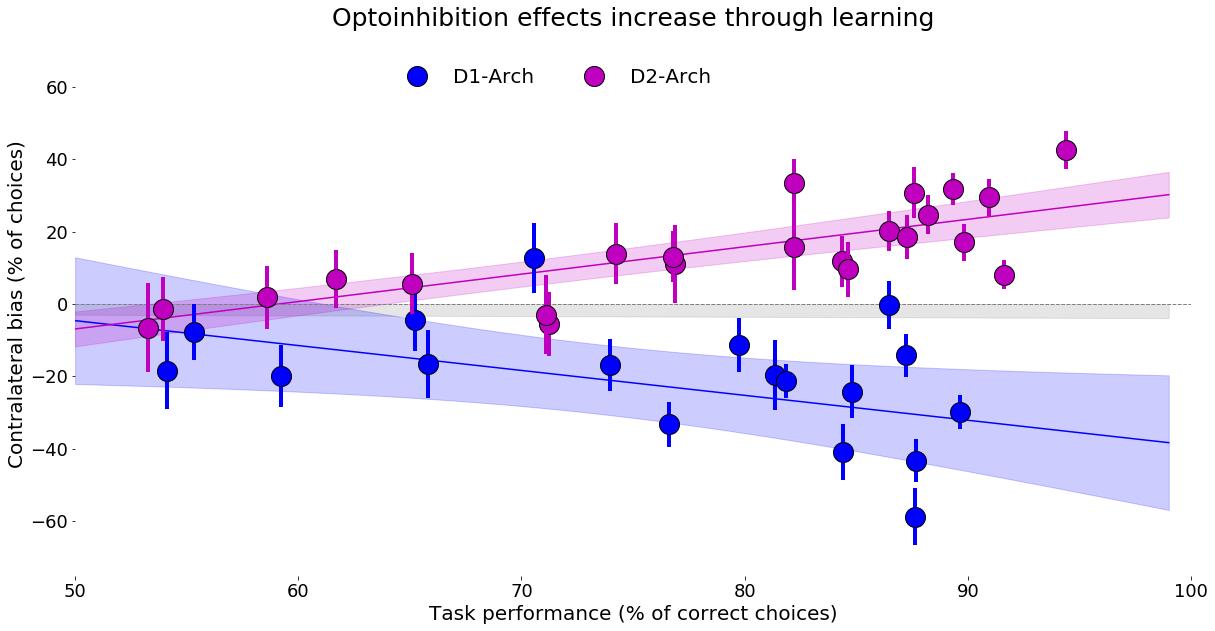

In [21]:
# put in the background of the main plot
# THIS WAY IS VERY UGLY THOUGH

# plot them all together
genotypes = ['D1opto', 'D2opto']
colors = ['b', 'm']
labels_for_legend = ['D1-Arch', 'D2-Arch']
animals = pd.unique(random_opto_df.AnimalID)

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.axhline(0, color='grey', linestyle='--', linewidth=1)

for an_c, animal in enumerate(animals):
    
    animal_rdf = random_opto_df[random_opto_df.AnimalID == animal]
    side_to_plot = side_selection[animal]
    
    for session in pd.unique(animal_rdf.SessionID):
        session_idx = animal_rdf.index[animal_rdf.SessionID == session].item()
        st_t = animal_rdf.loc[session_idx].stimulated_side
        if st_t == side_to_plot:
            sp = animal_rdf.loc[session_idx].session_performance
            cb = animal_rdf.loc[session_idx].contralateral_bias_exp
            cbs = animal_rdf.loc[session_idx].bias_std_exp
            genot = animal_rdf.loc[session_idx].Genotype
            g_idx = genotypes.index(genot)
            gfl = labels_for_legend[g_idx]
            
            ax.plot([sp, sp], [cb-cbs, cb+cbs], color=colors[g_idx], linewidth=4)
            ax.plot(sp, cb, 'o', ms=20, markerfacecolor=colors[g_idx], alpha = 1, label=gfl,
                    color='k')
            

# add regression          
for gcount, genotype in enumerate(np.unique(reg_dicc['genotypes'])):
    # find indexes for that genotype
    gmask = np.where([g == genotype for g in reg_dicc['genotypes']])[0]

    # get means and stds
    fits_array = np.zeros([len(gmask), len(xs)])
    for i, idx in enumerate(gmask):
        fits_array[i,:] = reg_dicc['fits'][idx]
    genot_means = np.mean(fits_array, axis=0)
    genot_stds = np.std(fits_array, axis=0)
    
    genot_idx = genotypes.index(genotype)
    
    plt.plot(xs, genot_means, color=colors[genot_idx], zorder=-30) #, label=labels_for_legend[genot_idx])
    plt.fill_between(xs, genot_means - genot_stds, genot_means + genot_stds,
                     color=colors[genot_idx], alpha=0.2, zorder=-50)
    
# plot random
plt.fill_between(xs,
                 group_shuffle_mean - group_shuffle_std,
                 group_shuffle_mean + group_shuffle_std,
                 color='grey', alpha=0.2, zorder=-100)

#beautify the plot
ax.set_ylim(-75, 75)
ax.set_xlim(50, 100)

# get rid of the frame
for spine in ax.spines.values():
    spine.set_visible(False)

# set labels
ax.set_ylabel('Contralateral bias (% of choices)', fontsize=20)
ax.set_xlabel('Task performance (% of correct choices)', fontsize=20)
ax.set_title('Optoinhibition effects increase through learning', fontsize=25)

# add legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), frameon=False, loc=(.32, .85), ncol=2, fontsize=20)
# ax.legend()
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(18) 

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(18)
plt.savefig(outputDir + output_directory_name + '_bias-through-learning-grouped_expected_side-selected_with-regression.pdf', transparent=True, bbox_inches='tight')

plt.show()

In [22]:
# calculate pvalue for the slope means
# use d1 and d2 separately for this
genotypes = ['D1opto', 'D2opto']
n_times = 100000

for genotype in genotypes:
    # find indexes for that genotype
    gmask = np.where([g == genotype for g in reg_dicc['genotypes']])[0]

    # get the actual slope mean
    slopes_list = []
    for idx in gmask:
        slopes_list.append(reg_dicc['reg_coefs'][idx][0])
    slope_mean = np.mean(slopes_list)
    
    # generate random samples and note how many times it is more extreme
    cross_counter = 0
    for k in range(n_times):
        # randomly sample one for each animal
        slopes_list = []
        for idx in gmask:
            shuffled_slopes = reg_dicc['shuffled_coefficients'][idx][0]
            slopes_list.append(np.random.choice(shuffled_slopes))
        slope_mean_random = np.mean(slopes_list)
        if genotype == 'D1opto':
            if slope_mean_random < slope_mean:
                cross_counter += 1
        if genotype == 'D2opto':
            if slope_mean_random > slope_mean:
                cross_counter += 1
    
    print('Genotype {} slope is {}, with a p-value of {}'.format(genotype, slope_mean, cross_counter/n_times))

Genotype D1opto slope is -0.6871763322171545, with a p-value of 0.03262
Genotype D2opto slope is 0.7563821784649638, with a p-value of 1e-05
